In [2]:
from natten import (
  NeighborhoodAttention1D,
  NeighborhoodAttention2D,
  NeighborhoodAttention3D,
)
na1d = NeighborhoodAttention1D(dim=128, kernel_size=7, dilation=3, num_heads=4)
na2d = NeighborhoodAttention2D(dim=128, kernel_size=7, dilation=3, num_heads=4)
na3d = NeighborhoodAttention3D(dim=128, kernel_size=7, dilation=3, num_heads=4)

In [3]:
na1d.extra_repr()

'head_dim=32, num_heads=4, kernel_size=7, dilation=3, has_bias=True'

In [10]:
from pathlib import Path
import pandas as pd

datapath = '/mnt/datadrive'
x = list(filter(lambda x: x.suffix=='.png', Path(datapath).rglob('*')))
df = pd.DataFrame(x, columns=['fullpath'])
df.head(5)

,fullpath
0,/mnt/datadrive/asos_dataset/tshirts_orig_biges...
1,/mnt/datadrive/asos_dataset/tshirts_orig_biges...
2,/mnt/datadrive/asos_dataset/tshirts_orig_biges...
3,/mnt/datadrive/asos_dataset/tshirts_orig_biges...
4,/mnt/datadrive/asos_dataset/tshirts_orig_biges...


In [15]:
df['item_idx'] = df['fullpath'].apply(lambda x: int(x.parent.stem))
df['item_idx'].value_counts()

item_idx
0      4
471    4
465    4
466    4
467    4
      ..
276    4
277    4
278    4
279    4
99     4
Name: count, Length: 609, dtype: int64

In [24]:
df.to_csv('all_imgs.csv', index=False)

In [23]:
from PIL import Image
from matplotlib import pyplot as plt

# for j in [0, 1, 2, 3, 44, 55, 99]:
#     for i in df[df['item_idx']==j]['fullpath'].values:
#         print(i)
#         img = Image.open(i)
#         plt.imshow(img)
#         plt.show()    

In [26]:
for group_idx, group in df.groupby(by='item_idx'):
    print(group_idx)
    print(group)
    break

0
                                            fullpath  item_idx
0  /mnt/datadrive/asos_dataset/tshirts_orig_biges...         0
1  /mnt/datadrive/asos_dataset/tshirts_orig_biges...         0
2  /mnt/datadrive/asos_dataset/tshirts_orig_biges...         0
3  /mnt/datadrive/asos_dataset/tshirts_orig_biges...         0


In [42]:
# image = Image.open(image_path).convert("RGB") 
image = Image.open('/mnt/datadrive/asos_dataset/tshirts_orig_bigest/9/2397.png').convert("RGB")
res = hp.forward_img(image).squeeze(0)

def get_clothing_agnostic(image, hp_mask, classes_to_rm=[4,6]):
    bg_color = (255,255,255)
    assert image.shape[:-1] == hp_mask.shape
    cloths_to_rm_mask = np.zeros(hp_mask.shape)
    for i in np.unique(res):
        if i in classes_to_rm:
            cloths_to_rm_mask[res==i] = 255
    image[cloths_to_rm_mask!=0] = bg_color
    return image


In [56]:
import numpy as np
# 4 === upper
# 6 === lower 

def get_clothing_agnostic(image, hp_mask, classes_to_rm=[4,6]):
    bg_color = (255,255,255)
    assert image.shape[:-1] == hp_mask.shape
    cloths_to_rm_mask = np.zeros(hp_mask.shape)
    for i in np.unique(res):
        if i in classes_to_rm:
            cloths_to_rm_mask[res==i] = 255
    image[cloths_to_rm_mask!=0] = bg_color
    return image

# xx = np.zeros(res.shape)
# for i in np.unique(res):
#     if i in [4,6]:
#         xx[res==i] = 255
# np_image = np.array(image)
# np_image[xx!=0] = (255,255,255)
# plt.imshow(np_image)
# plt.show()
print(np_image.shape[:-1])
# plt.imshow(xx)
# plt.show()

(2243, 1758)


In [4]:

import torch
from torch.utils.data import DataLoader, Dataset

from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from collections import defaultdict
from clothing_segmentation import HumanParser
import pandas as pd


class SyntheticTryonDataset(Dataset):
    def __init__(self, num_samples, image_size=(64,64), pose_size=(18, 2)):
        """
        Args:
            num_samples (int): Number of samples in the dataset.
            image_size (tuple): The height and width of the images (height, width).
            pose_size (tuple): The size of the pose tensors (default: (18, 2)).
        """
        self.human_parser = HumanParser()
        
        
        self.df = pd.read_csv('/home/roman/tryondiffusion_implementation/tryondiffusion_danny/all_imgs.csv')
        # self.item_ids = np.unique(self.df['item_idx'].values)
        self.items_reverse_index = {}
        for group_idx, group in self.df.groupby(by='item_idx'):
            self.items_reverse_index[group_idx] = group['fullpath'].values        
        
        self.num_samples = num_samples
        self.image_size = image_size
        self.pose_size = pose_size

    def __len__(self):
        return self.num_samples
    
    def prepare_clothing_agnostic(self, img, hp_mask)-> np.array: 
        classes_to_rm=[4,6]      
    # def get_clothing_agnostic(image, hp_mask, classes_to_rm=[4,6]):
        bg_color = (255,255,255)
        assert img.shape[:-1] == hp_mask.shape
        # cloths_to_rm_mask = np.zeros(hp_mask.shape)
        # for i in np.unique(res):
        #     if i in classes_to_rm:
        #         cloths_to_rm_mask[res==i] = 255
        cloths_to_rm_mask = np.isin(hp_mask, classes_to_rm)
        img[cloths_to_rm_mask!=0] = bg_color
        return img
        
    def prepare_pose(self, img):
        pass

    def prepare_segmented_garment(self, img, hp_mask)-> np.array:
        # classes_to_rm=[4,6] 
        classes_to_rm=[4]        
        bg_color = (255,255,255)
        assert img.shape[:-1] == hp_mask.shape
        # cloths_to_rm_mask = np.zeros(hp_mask.shape)
        # for i in np.unique(res):
        #     if i in classes_to_rm:
        #         cloths_to_rm_mask[res==i] = 255
        cloths_to_rm_mask = np.isin(hp_mask, classes_to_rm)
        img[cloths_to_rm_mask==0] = bg_color
        return img
        
    def __getitem__(self, idx):
        
        items_images_list = self.items_reverse_index[idx]
        img_person = items_images_list[0]
        img_garment = items_images_list[1]
        
        # inputs from img1
        # noisy
        # clothing agnostic
        # person pose
        # img = img.resize((768, 768), Image.BICUBIC)
        person_image = Image.open(img_person).convert('RGB').resize((768, 768), Image.BICUBIC)
        # print(person_image.size)
        # .resize(self.image_size, Image.BICUBIC)
        np_person_image = np.array(person_image)
        person_image_hp = self.human_parser.forward_img(person_image).squeeze(0)
        
        ca_image = self.prepare_clothing_agnostic(np_person_image, person_image_hp)
        # person_pose = self.prepare_pose(person_image.resize(self.image_size, Image.BICUBIC))
        
        # inputs from img2
        # garment pose
        # segmented garmend
        garment_image = Image.open(img_garment).convert('RGB').resize((768, 768), Image.BICUBIC)
        # print(garment_image.size)
        # .resize(self.image_size, Image.BICUBIC)
        np_garment_image = np.array(garment_image)
        garment_image_hp = self.human_parser.forward_img(garment_image).squeeze(0)
        
        segmented_garment = self.prepare_segmented_garment(np_garment_image, garment_image_hp) 
        # garment_pose = self.prepare_pose(garment_image.resize(self.image_size, Image.BICUBIC))
        
        # person_image = torch.randn(3, *self.image_size)
        # ca_image = torch.randn(3, *self.image_size)
        # garment_image = torch.randn(3, *self.image_size)
        # person_pose = torch.randn(*self.pose_size)
        # garment_pose = torch.randn(*self.pose_size)

        # sample = {
        #     "person_images": person_image,
        #     "ca_images": ca_image,
        #     "garment_images": garment_image,
        #     "person_poses": person_pose,
        #     "garment_poses": garment_pose,
        # }

        # TODO transforms PIL Images to Tensors, Normalization
        sample = {
            "person_images": person_image.resize(self.image_size, Image.BICUBIC),
            "ca_images": Image.fromarray(ca_image.astype('uint8')).resize(self.image_size, Image.BICUBIC),
            "garment_images": Image.fromarray(segmented_garment.astype('uint8')).resize(self.image_size, Image.BICUBIC),
            # "person_poses": person_pose,
            # "garment_poses": garment_pose,
        }
        
        return sample


def tryondiffusion_collate_fn(batch):
    return {
        "person_images": torch.stack([item["person_images"] for item in batch]),
        "ca_images": torch.stack([item["ca_images"] for item in batch]),
        "garment_images": torch.stack([item["garment_images"] for item in batch]),
        "person_poses": torch.stack([item["person_poses"] for item in batch]),
        "garment_poses": torch.stack([item["garment_poses"] for item in batch]),
    }

ds = SyntheticTryonDataset(num_samples=100)
for i in ds:
    print(i.keys())
    break

dict_keys(['person_images', 'ca_images', 'garment_images'])


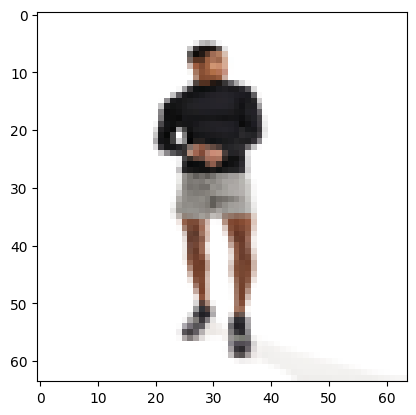

In [5]:
plt.imshow(i['person_images'])

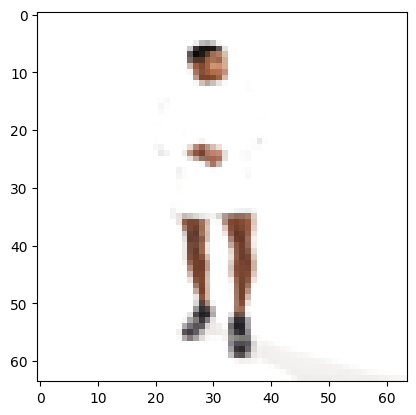

In [6]:
plt.imshow(i['ca_images'])

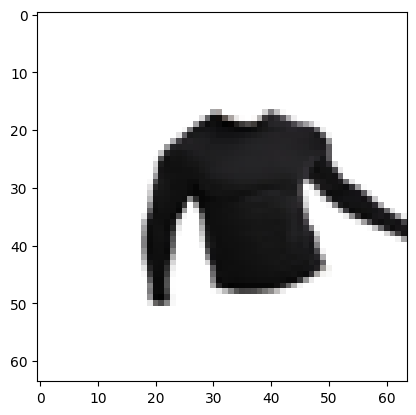

In [7]:
plt.imshow(i['garment_images'])